Let's see if we can add our own CMAP to gmx, using ParmEd
Steps:
- load gmx topology with parmed
- identify the indices (and possibly the atom objects) of the atoms that form the backbone dihedrals
- we need to match the mdtraj atoms to the parmed ones
- add cmaptypes and cmaps to parmed topology and export 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import copy
import numpy as np
import parmed as pmd
import mdtraj as mdt
from parmed.topologyobjects import CmapType, Cmap
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("../../")
from data_utils import build_cmap_atoms

/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TODO: match mdtraj atoms to parmed ones 

1) parmed atom -> mdtraj atom
2) mdtraj atom -> mdtraj index (for the angles array)


In [4]:

# basepath = "/data/gzappavigna/lmp_conf_builder/gmx/amber/"
# basepath = "./a99-ildn/"
ref_basepath = "/data/gzappavigna/traj/a99sb-ildn_opc/"

# ref_traj = mdt.iterload(basepath + "step5_production_nojump.xtc", top=basepath + "step5_production_nojump.pdb")
ref_traj = mdt.load(ref_basepath + "step5_production_nojump.xtc", top=ref_basepath + "step5_production_nojump.pdb", stride=20)


In [5]:
ens_basepath = "/data/gzappavigna/lmp_conf_builder/runs/"

ens_traj = mdt.load(ens_basepath + "ensemble.xtc", top=ens_basepath + "cg.pdb")

/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


In [6]:
from cmap import build_phipsi, compute_pdf_r

ens_phipsi = build_phipsi(ens_traj)
ref_phipsi = build_phipsi(ref_traj)


In [7]:
_, counts = np.unique(ens_phipsi[33], axis=0, return_counts=True)
np.sum(counts > 1)

123

In [8]:
# import h5py

# f = h5py.File("phipsi.hdf5", "w")
# ens_grp = f.create_group("ens")
# ens_phipsi_dset = ens_grp.create_dataset("phipsi", ens_phipsi.shape, dtype='f')
# ens_phipsi_dset[()] = ens_phipsi

# ref_grp = f.create_group("ref")
# ref_phipsi_dset = ref_grp.create_dataset("phipsi", ref_phipsi.shape, dtype='f')
# ref_phipsi_dset[()] = ref_phipsi

# f.close()


In [19]:
basepath = "./a99-ildn/"
pmd_top = pmd.load_file(basepath + "topol.top", xyz=basepath + "6921a_solv_ions.gro") # defines={"POSRES": 1})

In [20]:
cmap_atoms_list = build_cmap_atoms([[getattr(dih, f"atom{i+1}") for i in range(4)] for dih in pmd_top.dihedrals])

In [21]:
id_to_mdt_atom = {(atom.residue.index, atom.name): atom for atom in ref_traj.top.atoms}

residueNameReplacements = mdt.formats.pdb.PDBTrajectoryFile._residueNameReplacements
atomNameReplacements = mdt.formats.pdb.PDBTrajectoryFile._atomNameReplacements

pmd_atoms = [atom for atom in pmd_top.atoms if atom.residue.name not in {"SOL", "CL", "NA"}]

pmd_to_mdt_atom = {}

for pmd_atom in pmd_atoms:
    res = pmd_atom.residue
    mdt_resname = residueNameReplacements[res.name]
    mdt_name = atomNameReplacements[mdt_resname].get(pmd_atom.name, pmd_atom.name)
    mdt_atom = id_to_mdt_atom[(res.idx, mdt_name)]

    pmd_to_mdt_atom[pmd_atom] = mdt_atom

In [44]:
from cmap import build_phipsi, build_cmap

# ens_phipsi = build_phipsi(ens_traj)
# ref_phipsi = build_phipsi(ref_traj)

cmap_types = []
cmap_objs = []

def add_idx_to_atom(atom, i):
    atom_type = copy(atom.atom_type)
    new_name = atom_type.name + f"_{i}"
    atom_type.name = new_name
    atom.atom_type = atom_type
    atom.type = new_name

c_first = cmap_atoms_list[0][0]
add_idx_to_atom(c_first, 0)

n_last = cmap_atoms_list[-1][-1]
add_idx_to_atom(n_last, len(cmap_atoms_list) + 1)

for i, cmap_atoms in enumerate(cmap_atoms_list):
    for atom in cmap_atoms[1:-1]:
        add_idx_to_atom(atom, i+1)

cmap_mins = []

for cmap_atoms in cmap_atoms_list:
    mdt_atoms = [pmd_to_mdt_atom[atom] for atom in cmap_atoms]
    # the third is the CA
    cmap_ind = mdt_atoms[2].residue.index
    assert mdt_atoms[2].name == "CA"
    resname = mdt_atoms[2].residue.name
    print(cmap_ind)

    sel_ens_phipsi = ens_phipsi[cmap_ind]
    sel_ref_phipsi = ref_phipsi[cmap_ind]

    cmap, *_ = build_cmap(sel_ens_phipsi, sel_ref_phipsi, basepath=f"./plots/{resname}{cmap_ind + 1}") # ens_bw=0.4, ref_bw=0.2)
    cmap_mins.append(np.min(cmap))
    cmap_type = CmapType(resolution=24, grid=cmap.flatten().tolist(), comments=[resname])
    cmap_type.used = True
    cmap_obj = Cmap(*cmap_atoms, type=cmap_type)
    cmap_types.append(cmap_type)
    cmap_objs.append(cmap_obj)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


(array([ 4., 12., 38., 33., 14., 16.,  6.,  2.,  3.,  1.]),
 array([-7.63094262, -7.34472963, -7.05851663, -6.77230364, -6.48609064,
        -6.19987765, -5.91366466, -5.62745166, -5.34123867, -5.05502567,
        -4.76881268]),
 <BarContainer object of 10 artists>)

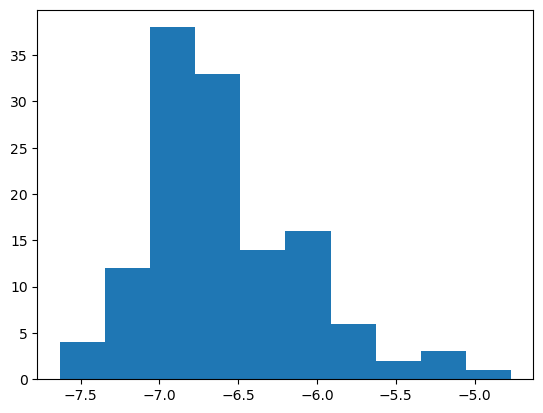

In [45]:
cmap_mins = np.asarray(cmap_mins)
plt.hist(cmap_mins[cmap_mins < -4])

In [46]:
pmd_top.cmap_types.clear()
pmd_top.cmaps.clear()

pmd_top.cmap_types.extend(cmap_types)
pmd_top.cmap_types.claim()
pmd_top.cmap_types.index_members()

pmd_top.cmaps.extend(cmap_objs)
pmd_top.cmaps.claim()
pmd_top.cmaps.index_members()

In [47]:
pmd_top.save(basepath + "cmap_topol.top", overwrite=True)
pmd_top.save(basepath + "cmap.gro", overwrite=True)

In [48]:
def get_index_of_type(lines: list[str], target):
    for i, line in enumerate(lines):
        tokens = line.split()

        if tokens != ["[", "moleculetype", "]"]:
            continue

        names = []

        for line in lines[i+1:]:
            stripped = line.lstrip()

            if stripped.startswith(";") or stripped == "":
                continue

            if stripped.startswith("["):
                break

            names.append(stripped.split()[0])

        if len(names) != 1:
            raise Exception

        name = names[0]

        if name == target:
            return i

    raise Exception


In [49]:
# TODO: turn this into a function

with open(basepath + "cmap_topol.top") as top:
    lines = top.readlines()

i_sol = get_index_of_type(lines, "SOL")

lines[i_sol:i_sol] = ["#ifdef POSRES\n", '#include "posre.itp"\n', "#endif\n", "\n"]

i_ions = min(get_index_of_type(lines, ion_type) for ion_type in ["NA", "CL"])

lines[i_ions:i_ions] = [
    "#ifdef POSRES_WATER\n",
    "; Position restraint for each water oxygen\n",
    "[ position_restraints ]\n",
    ";  i funct       fcx        fcy        fcz\n",
    "   1    1       1000       1000       1000\n",
    "#endif\n",
    "\n",
]

with open(basepath + "cmap_topol_fixed.top", "w") as top:
    top.writelines(lines)


In [50]:
!realpath {basepath + "cmap_topol_fixed.top"}

/data/gzappavigna/lmp_conf_builder/notebooks/cmap/a99-ildn/cmap_topol_fixed.top
